## Importing libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings("ignore")

In [2]:
raw_data = pd.read_csv('cars_price.csv')
data = raw_data.copy()
data = data.drop("Unnamed: 0", axis = 1)

In [3]:
data.head()

,make,model,priceUSD,year,condition,mileage(kilometers),fuel_type,volume(cm3),color,transmission,drive_unit,segment
0,honda,accord,565,1993,with mileage,960015.0,petrol,2000.0,black,mechanics,front-wheel drive,D
1,ford,fusion,5550,2008,with mileage,172000.0,diesel,1400.0,silver,mechanics,front-wheel drive,M
2,nissan,teana,8300,2008,with mileage,223000.0,petrol,2500.0,purple,auto,front-wheel drive,D
3,volkswagen,fox,3300,2005,with mileage,140000.0,petrol,1200.0,blue,mechanics,front-wheel drive,A
4,nissan,primera,2450,2002,with damage,413000.0,diesel,2200.0,burgundy,mechanics,front-wheel drive,D


In [4]:
data['make'].nunique()

93

#### Checking Null values

In [5]:
data.isnull().sum()

make                      0
model                     0
priceUSD                  0
year                      0
condition                 0
mileage(kilometers)       0
fuel_type                 0
volume(cm3)              30
color                     0
transmission              0
drive_unit             1345
segment                3755
dtype: int64

We got some null values in 'volume(cm3)', 'drive_unit', 'segment'.

Among these, 'volume(cm3)' is numerical, and 'drive_unit and 'segment' both are categorical features.

#### Imputing numerical features

In [6]:
def numerical_null_impute(data, feature_names, method = 'mean'):
    """
    Parameters:
    data: The datatset
    feature_names: A list of feature names that needs to be imputed
    method: The imputation method, i.e mean, median or mode (default = mean)
    """
    
    for x in feature_names: #For each feature name
        #Perfoming action according to method
        if method == 'mean':
            #Filling null values for each feature name
            data[x].fillna(data[x].mean(), inplace=True)
            print("Null values imputed with mean.")
        
        elif method == 'median':
            #Filling null values for each feature name
            data[x].fillna(data[x].median(), inplace=True)
            print("Null values imputed with median.")

            
        elif method == 'mode':
            #Filling null values for each feature name
            data[x].fillna(data[x].mode(), inplace=True)
            print("Null values imputed with mode.")

            
        else:
            print("Enter a proper method name (mean, median, mode)")
    

In [7]:
feature_names = ['volume(cm3)']
numerical_null_impute(data, feature_names, method = 'median')

Null values imputed with median.


#####    

#### Imputing categorical features

Null value imputation for Categorical features is a bit tricky. It requires carefull implementation and without proper method might lead to bad results during model training.

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

def categorical_null_impute(data, feature_names):
    """
    This function will use KMeans Clustering to impute missing values for categorical data in the dataset.
    
    Paramters: 
    data: The dataset
    feature_names: A list of feature names that needs to be imputed
    """
    temp_data = data.copy() #Creating a copy of the original data
    
    for x in feature_names: #For each feature name
        
        """
        Seperate into two dataframes, one with null values, one without null values
        1. The dataframe without null values will be used for training set,
        2. The dataframe wih null values will be used for test dataset
        """
        data_with_null = temp_data[pd.isnull(temp_data[x])]

        data_without_null = temp_data[pd.notnull(temp_data[x])]

        num_cols = list(temp_data._get_numeric_data().columns.values) #Gathering only numerical columns
        
        #Train sets
        x_train = data_without_null.drop(x, axis = 1)
        y_train = data_without_null[x]

        #Test sets
        x_test = data_with_null.drop(x, axis = 1)
        y_test = data_with_null[x]

        #We need to extract the numerical columns, and with those columns and their values,
        #We can scale those values and perform KNN algorithm
        x_train = x_train[num_cols]
        x_test = x_test[num_cols]
        
        #Scaling data 
        scaler = StandardScaler()
        
        x_train_scaled = scaler.fit_transform(x_train)
        x_test_scaled = scaler.transform(x_test)
        
        #Implementing K Nearest neighbours algorithm
        knn = KNeighborsClassifier()
        knn.fit(x_train_scaled, y_train)

        pred = knn.predict(x_test_scaled)
        
        #Assigning the null values with the predicted values
        data_with_null[x] = pred

        #Finally filling the null values with the predicted values
        data[x].fillna(data_with_null[x], inplace= True)
        
    print("Imputed Null values for Categorical features using K Nearest neighbors classifier algorithm")
    print("Showing status of dataframe after imputation: ")

    print(data.isnull().sum())

In [9]:
feature_names = ['drive_unit', 'segment']
categorical_null_impute(data, feature_names)

Imputed Null values for Categorical features using K Nearest neighbors classifier algorithm
Showing status of dataframe after imputation: 
make                   0
model                  0
priceUSD               0
year                   0
condition              0
mileage(kilometers)    0
fuel_type              0
volume(cm3)            0
color                  0
transmission           0
drive_unit             0
segment                0
dtype: int64


#####   

**During Data Analysis, we saw that the Price column, i.e our predictive feature is prone to outliers.**

Machine learning algorithms are sensitive to the range and distribution of attribute values. Data outliers can spoil and mislead the training process resulting in longer training times, less accurate models and ultimately poorer results.



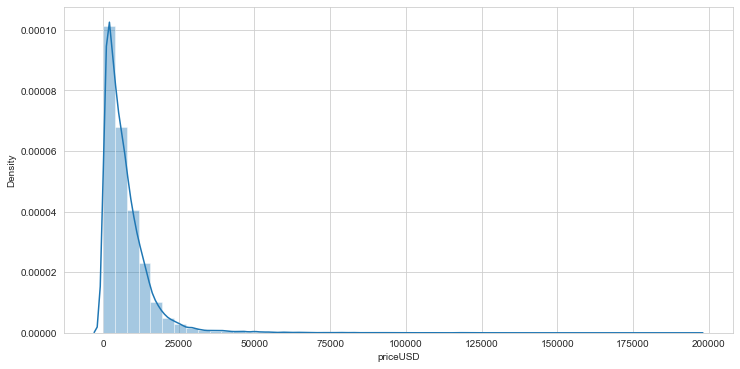

In [10]:
plt.figure(figsize = (12,6))
sns.distplot(data['priceUSD'])
plt.show()

This influence of outliers can affect further during ML model creation and implementation of algorithms as most algorithms perform poorly in presence of outliers.

To handle outliers, we will basically limit the dataset upto a certain quantile range.

We will set the quantile value to 0.97, i.e retaining 97% of the data, while removing 3% that contains most of the outliers

In [11]:
q = data['priceUSD'].quantile(0.97)

data = data[data['priceUSD'] < q]

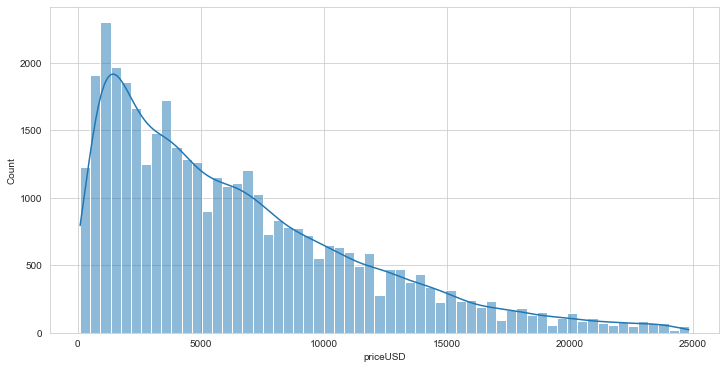

In [12]:
plt.figure(figsize = (12,6))
sns.histplot(data['priceUSD'], kde = True)
plt.show()

The price distribution looks much better now and most of the information is retained.

#####   

**We also found out that fuel_type and transmission are correlated with each other, that means they have a significant relationship between them that can affect model performance.**

A quick research shoes that users generally prefer manual / mechanics transmission type since there are a lot of disadvantages of automatic transmission type cars like expensive parts, expensive repairs etc.

Users generally look for fuel type in a car rather than transmission type as most people prefer a manual type.

Since, users generally are more focused on fuel_type, we can just drop the transmission column altogether.

In [13]:
data = data.drop('transmission', axis = 1)

The make and model columns together represents a single car model. We can combine these two into a single feature.

In [14]:
data['brand_and_model'] = data['make'].str.cat(data['model'], sep =" ")

data = data.drop(['make', 'model'], axis = 1)

######   

### Categorical Encoding

in this section, all the categorical features in the dataset will be converted to numerical encodings. This is the final step before model creation.

We will create a function that will convert categorical features into dummy variables. This method is known as One-Hot Encoding.

In [15]:
def categorical_encoding(data, features = None):
    """
    The function will convert categorical features to numerical values using One-Hot encoding technique
    
    Parameters:
    data: The dataset
    features: A list of the categorical feature names that needs to be one-hot encoded
                By default 'None', it will convert all categorical features present in the dataset
    Returns:
    A dataframe which has been one-hot encoded 
    """
    if features == None:
        
        """
        1. Gather the numerical features
        2. Gather the columns from the dataset except the numerical features
        """
        numeric_cols = list(data._get_numeric_data().columns.values) 
        categorical_cols = list(data.drop(numeric_cols, axis = 1).columns.values) 
        
        features = categorical_cols
        
        
    for x in features: #For each feature name
        
        """
        1. Create dummies of those feature's categories
        2. Conatenate them with the original dataset
        """
        
        dummies = pd.get_dummies(data[x], drop_first = True)
        data = pd.concat([dummies,data], axis = 1)

        data = data.drop(x, axis = 1)
        
    return data

In [16]:
data = categorical_encoding(data)

In [17]:
data

,acura legend,acura mdx,acura rdx,acura rl,acura rsx,acura tl,acura tlx,acura tsx,acura zdx,alfa-romeo 145,...,white,yellow,electrocar,petrol,with damage,with mileage,priceUSD,year,mileage(kilometers),volume(cm3)
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,565,1993,960015.0,2000.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,5550,2008,172000.0,1400.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,8300,2008,223000.0,2500.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,3300,2005,140000.0,1200.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,2450,2002,413000.0,2200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,12500,2008,214000.0,3700.0
39996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,4754,2001,295000.0,2200.0
39997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,4000,1999,0.0,2200.0
39998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,1200,1996,250000.0,1300.0


##### Finally saving the dataframe into a csv file for final use in model creation and evaluation

In [18]:
data.to_csv('used_cars_price_cleaned.csv')